THIS UBER DATASET FARE PREDICTION PREDICT TOTAL FARE AMOUNT USING THE BELOW DATASET FOR PRICING DEMAND 

In [99]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go   
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
import joblib
import json

In [ ]:

def wrangle (filepath):
    df = pd.read_csv(filepath)  # Load your dataset
    
    # NO MISSING VALUE
    #  NO OUTLIERS
    # LEAKY FEATURES
    df.drop(columns=['dropoff_longitude','dropoff_latitude','fare_amount', 'tpep_dropoff_datetime','store_and_fwd_flag', 
       'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge'], inplace= True)
    # No MULTICOLINEARITY
    # FEATURE ENGINEERING
    df = df.copy()
   
    # ============================================================
    # 1. DATETIME FEATURES (from tpep_pickup_datetime)
    # ============================================================
    
    df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    
    # Basic time features
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
    
    # Cyclical encoding for hour (since 23:00 and 00:00 are close)
    df['hour_sin'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
    
    # Cyclical encoding for day of week
    df['day_sin'] = np.sin(2 * np.pi * df['pickup_dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['pickup_dayofweek'] / 7)
    
    # Binary flags
    df['is_weekend'] = (df['pickup_dayofweek'] >= 5).astype(int)  # Sat=5, Sun=6
    
    # Rush hour (morning: 7-9 AM, evening: 4-7 PM)
    df['is_morning_rush'] = df['pickup_hour'].isin([7, 8, 9]).astype(int)
    df['is_evening_rush'] = df['pickup_hour'].isin([16, 17, 18, 19]).astype(int)
    df['is_rush_hour'] = ((df['is_morning_rush'] == 1) | 
                          (df['is_evening_rush'] == 1)).astype(int)
    
    # Time of day categories
    def get_time_of_day(hour):
        if 6 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        elif 21 <= hour < 24:
            return 'night'
        else:  # 0-5
            return 'late_night'
    
    df['time_of_day'] = df['pickup_hour'].apply(get_time_of_day)
    
    # Late night flag (higher fares, fewer drivers)
    df['is_late_night'] = ((df['pickup_hour'] >= 0) & 
                           (df['pickup_hour'] < 6)).astype(int)
    
    # Business hours
    df['is_business_hours'] = ((df['pickup_hour'] >= 9) & 
                               (df['pickup_hour'] < 17) & 
                               (df['pickup_dayofweek'] < 5)).astype(int)
    
    # ============================================================
    # 2. LOCATION FEATURES (from coordinates)
    # ============================================================
    
    # NYC airport coordinates
    JFK_COORD = (40.6413, -73.7781)
    LAGUARDIA_COORD = (40.7769, -73.8740)
    NEWARK_COORD = (40.6895, -74.1745)
    
    # Manhattan center (Times Square area)
    MANHATTAN_CENTER = (40.7580, -73.9855)
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """Calculate distance in miles between two coordinates"""
        R = 3959  # Earth radius in miles
        
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        return R * c
    
    # Distance from key locations
    df['pickup_dist_from_jfk'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        JFK_COORD[0], JFK_COORD[1]
    )
    
    df['pickup_dist_from_lga'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        LAGUARDIA_COORD[0], LAGUARDIA_COORD[1]
    )
    
    df['pickup_dist_from_ewr'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        NEWARK_COORD[0], NEWARK_COORD[1]
    )
    
    df['pickup_dist_from_manhattan'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        MANHATTAN_CENTER[0], MANHATTAN_CENTER[1]
    )
    
    # Airport flags (within 1 mile)
    df['pickup_at_jfk'] = (df['pickup_dist_from_jfk'] < 1).astype(int)
    df['pickup_at_lga'] = (df['pickup_dist_from_lga'] < 1).astype(int)
    df['pickup_at_ewr'] = (df['pickup_dist_from_ewr'] < 1).astype(int)
    df['pickup_at_airport'] = ((df['pickup_at_jfk'] == 1) | 
                               (df['pickup_at_lga'] == 1) | 
                               (df['pickup_at_ewr'] == 1)).astype(int)
    
    # Manhattan flag (rough boundaries)
    df['pickup_in_manhattan'] = (
        (df['pickup_latitude'] >= 40.7000) & 
        (df['pickup_latitude'] <= 40.8200) &
        (df['pickup_longitude'] >= -74.0200) & 
        (df['pickup_longitude'] <= -73.9000)
    ).astype(int)
    
    # ============================================================
    # 3. TRIP FEATURES
    # ============================================================
    
    # Speed estimate (miles per hour)
    # Note: Only if you have dropoff_datetime available
    if 'tpep_dropoff_datetime' in df.columns:
        df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        df['trip_duration_seconds'] = (
            df['dropoff_datetime'] - df['pickup_datetime']
        ).dt.total_seconds()
        df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60
        
        # Average speed (trip_distance is in miles)
        df['avg_speed_mph'] = (
            df['trip_distance'] / (df['trip_duration_minutes'] / 60)
        ).replace([np.inf, -np.inf], np.nan)
    
    # Distance categories
    def categorize_distance(distance):
        if distance < 1:
            return 'very_short'
        elif distance < 3:
            return 'short'
        elif distance < 7:
            return 'medium'
        elif distance < 15:
            return 'long'
        else:
            return 'very_long'
    
    df['distance_category'] = df['trip_distance'].apply(categorize_distance)
    
    # Log transform of distance (helps with skewed distribution)
    df['log_trip_distance'] = np.log1p(df['trip_distance'])
    
    # ============================================================
    # 4. INTERACTION FEATURES
    # ============================================================
    
    # Distance × Rush hour (longer trips during rush hour cost more)
    df['distance_rush_interaction'] = df['trip_distance'] * df['is_rush_hour']
    
    # Distance × Weekend
    df['distance_weekend_interaction'] = df['trip_distance'] * df['is_weekend']
    
    # Airport × Late night (expensive combination)
    df['airport_latenight_interaction'] = (
        df['pickup_at_airport'] * df['is_late_night']
    )
    
    # Manhattan × Business hours
    df['manhattan_business_interaction'] = (
        df['pickup_in_manhattan'] * df['is_business_hours']
    )
    
    # ============================================================
    # 5. PASSENGER FEATURES
    # ============================================================
    
    # Handle outliers in passenger_count
    df['passenger_count'] = df['passenger_count'].clip(1, 6)
    
    # Group size category
    df['is_solo'] = (df['passenger_count'] == 1).astype(int)
    df['is_group'] = (df['passenger_count'] >= 4).astype(int)
    
    # ============================================================
    # 6. AGGREGATED/STATISTICAL FEATURES (Advanced)
    # ============================================================
    
    # Average fare by hour (requires historical data)
    # This creates a target-based feature - use with caution (potential leakage)
    # Only calculate on training set, then map to test set
    
    # Example: Average trip distance by hour
    # hour_distance_mean = df.groupby('pickup_hour')['trip_distance'].transform('mean')
    # df['hour_avg_distance'] = hour_distance_mean
    
    return df

In [4]:
df = wrangle('uber_data.csv')  # Load your dataset

In [15]:
df.head()  # Display the first few rows of the dataframe
print("df shape:", df.shape)

df shape: (100000, 42)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   VendorID                        100000 non-null  int64         
 1   tpep_pickup_datetime            100000 non-null  object        
 2   passenger_count                 100000 non-null  int64         
 3   trip_distance                   100000 non-null  float64       
 4   pickup_longitude                100000 non-null  float64       
 5   pickup_latitude                 100000 non-null  float64       
 6   RatecodeID                      100000 non-null  int64         
 7   total_amount                    100000 non-null  float64       
 8   pickup_datetime                 100000 non-null  datetime64[ns]
 9   pickup_hour                     100000 non-null  int32         
 10  pickup_day                      100000 non-null  int32   

In [7]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,total_amount,pickup_datetime,pickup_hour,pickup_day,...,pickup_at_ewr,pickup_at_airport,pickup_in_manhattan,log_trip_distance,distance_rush_interaction,distance_weekend_interaction,airport_latenight_interaction,manhattan_business_interaction,is_solo,is_group
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.88327,1.929200,3.034270,-73.288983,40.375220,1.040120,16.390721,2016-03-08 06:42:50.246160128,8.382800,7.910200,...,0.000020,0.042670,0.925650,1.142521,0.842121,0.0,0.009010,0.518710,0.654960,0.167190
min,1.00000,1.000000,0.000000,-121.933327,0.000000,1.000000,-47.300000,2016-03-01 00:00:00,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.00000,1.000000,0.990000,-73.990959,40.738891,1.000000,8.300000,2016-03-10 07:18:30,7.000000,10.000000,...,0.000000,0.000000,1.000000,0.688135,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,2.00000,1.000000,1.670000,-73.980202,40.755299,1.000000,11.800000,2016-03-10 09:29:43.500000,9.000000,10.000000,...,0.000000,0.000000,1.000000,0.982078,0.000000,0.0,0.000000,1.000000,1.000000,0.000000
75%,2.00000,2.000000,3.200000,-73.964203,40.769021,1.000000,18.300000,2016-03-10 12:03:33.249999872,12.000000,10.000000,...,0.000000,0.000000,1.000000,1.435085,0.910000,0.0,0.000000,1.000000,1.000000,0.000000
max,2.00000,6.000000,184.400000,0.000000,41.204548,6.000000,832.800000,2016-03-10 14:27:09,14.000000,10.000000,...,1.000000,1.000000,1.000000,5.222516,48.180000,0.0,1.000000,1.000000,1.000000,1.000000
std,0.32110,1.589381,3.846951,7.089652,3.901413,0.284238,14.437180,NaN,3.996454,3.800142,...,0.004472,0.202113,0.262341,0.637662,2.208801,0.0,0.094493,0.499652,0.475384,0.373147


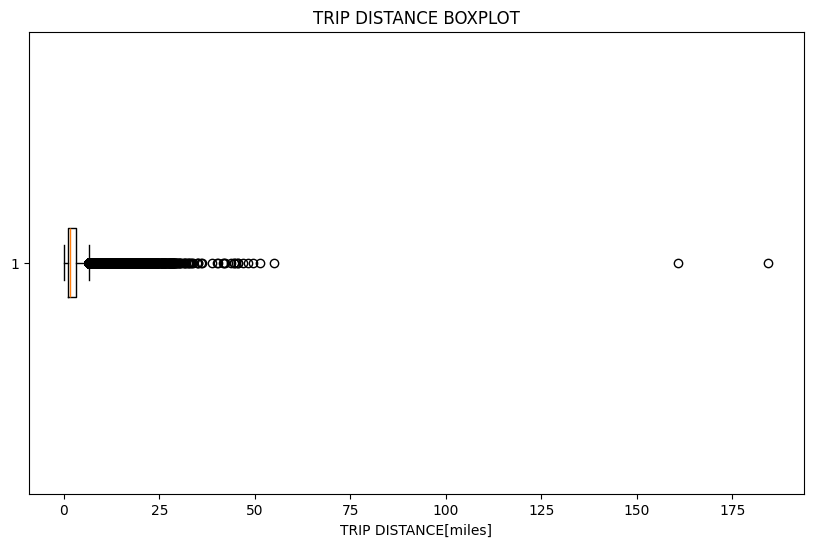

In [16]:
fig, ax= plt.subplots(figsize=(10,6))

ax.boxplot(df["trip_distance"], vert=False);

ax.set_xlabel("TRIP DISTANCE[miles]");
ax.set_title("TRIP DISTANCE BOXPLOT");

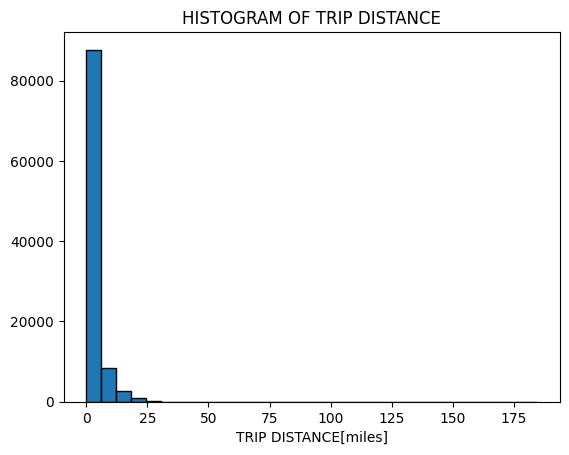

In [17]:
plt.hist(df["trip_distance"], bins=30, edgecolor='black')
plt.xlabel("TRIP DISTANCE[miles]");
plt.title("HISTOGRAM OF TRIP DISTANCE");

In [19]:
df.describe()["trip_distance"]

count    100000.000000
mean          3.034270
min           0.000000
25%           0.990000
50%           1.670000
75%           3.200000
max         184.400000
std           3.846951
Name: trip_distance, dtype: float64

In [20]:
# OUTLIERS IN TRIP DISTANCE NOT REMOVED DUR TO MODEL ROBUSTNESS (xgboost) HANDLES OUTLIERS)

Text(0.5, 1.0, 'Trip Distance vs Total Amount')

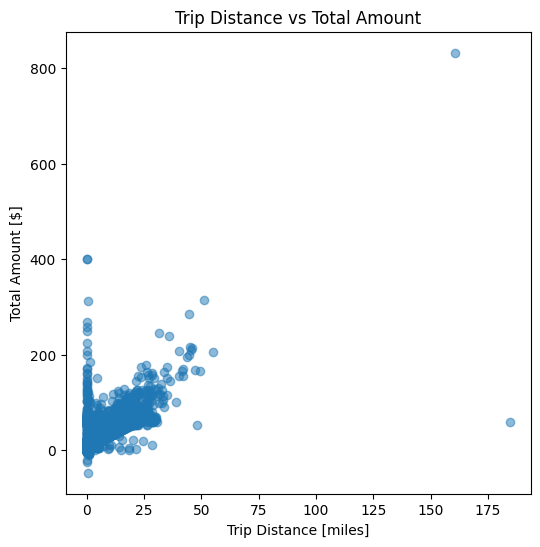

In [25]:
# SCATTER PLOT OF THE MOST IMPORTANT FEATURES AGAINST TARGET VARIABLE

plt.figure(figsize=(6,6))
plt.scatter(df['trip_distance'], df['total_amount'], alpha=0.5)
plt.xlabel('Trip Distance [miles]')
plt.ylabel('Total Amount [$]')
plt.title('Trip Distance vs Total Amount')

In [ ]:
#cor = df.select_dtypes(include= [np.number]).corr()

In [30]:
#sns.heatmap(cor, annot=True, cmap="coolwarm")
# To check for Multicolinearity 

In [13]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'total_amount',
       'pickup_datetime', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_year', 'pickup_dayofweek', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'is_weekend', 'is_morning_rush', 'is_evening_rush',
       'is_rush_hour', 'time_of_day', 'is_late_night', 'is_business_hours',
       'pickup_dist_from_jfk', 'pickup_dist_from_lga', 'pickup_dist_from_ewr',
       'pickup_dist_from_manhattan', 'pickup_at_jfk', 'pickup_at_lga',
       'pickup_at_ewr', 'pickup_at_airport', 'pickup_in_manhattan',
       'distance_category', 'log_trip_distance', 'distance_rush_interaction',
       'distance_weekend_interaction', 'airport_latenight_interaction',
       'manhattan_business_interaction', 'is_solo', 'is_group'],
      dtype='object')

# SPLIT FOR MODELLING

In [ ]:
# FEATURE SELECTION
features = ["trip_distance","pickup_hour","is_rush_hour","pickup_in_manhattan","distance_rush_interaction"]
X = df[features]

In [35]:
# Target variable
y = df["total_amount"]

In [36]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# BASELINE MODEL: XGBOOST REGRESSOR 
# predict average total fare for all trips

mean_total_amount  = y_train.mean()
y_pred_baseline = [mean_total_amount] * len(y_test)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline) 

print(f"Strategy: Predict the $ average total_amount for all trips")
print(f"Baseline MAE: ${mae_baseline:.2f}")
print(f"Baseline RMSE: ${rmse_baseline:.2f}")
print(f"Baseline R2: {r2_baseline:.2f}")

Strategy: Predict the $ average total_amount for all trips
Baseline MAE: $9.01
Baseline RMSE: $14.23
Baseline R2: -0.00


In [47]:
# BASELINE MODEL 2: XGBOOST REGRESSOR
# MEDIAN MORE ROBUST TO OUTLIERS

median_total_amount  = y_train.median()
y_pred_baseline2 = [median_total_amount] * len(y_test)  
    
mae_baseline2 = mean_absolute_error(y_test, y_pred_baseline2)
rmse_baseline2 = np.sqrt(mean_squared_error(y_test, y_pred_baseline2))
r2_baseline2 = r2_score(y_test, y_pred_baseline2)

print(f"Strategy: Predict the $ median total_amount for every trip")
print(f"Baseline2 MAE: ${mae_baseline2:.2f}")
print(f"Baseline2 RMSE: ${rmse_baseline2:.2f}")
print(f"Baseline2 R2: {r2_baseline2:.2f}")

Strategy: Predict the $ median total_amount for every trip
Baseline2 MAE: $8.06
Baseline2 RMSE: $14.98
Baseline2 R2: -0.11


In [55]:
# TRAIN XGBOOST REGRESSOR MODEL
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [63]:

# FIT THE MODEL
xgb_model.fit(X_train, y_train)

# PREDICT ON TRAIN SET
y_pred_xgb = xgb_model.predict(X_train)

# EVALUATION METRICS
print(f"Xgb_model MAE: {mean_absolute_error(y_train, y_pred_xgb):.2f}")

rmse = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"Xgb_model RMSE: {rmse:.2f}")

print(f"Xgb_model R2: {r2_score(y_train, y_pred_xgb):.2f}")


Xgb_model MAE: 2.45
Xgb_model RMSE: 6.26
Xgb_model R2: 0.81


In [64]:
# PREDICT ON TEST SET
y_pred_xgb_test = xgb_model.predict(X_test)

# EVALUATION METRICS
print(f"Xgb_model TEST MAE: {mean_absolute_error(y_test, y_pred_xgb_test):.2f}")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
print(f"Xgb_model TEST RMSE: {rmse_test:.2f}")

print(f"Xgb_model TEST R2: {r2_score(y_test, y_pred_xgb_test):.2f}")


Xgb_model TEST MAE: 2.47
Xgb_model TEST RMSE: 5.35
Xgb_model TEST R2: 0.86


# COMMUNICATE RESULT

In [85]:
# INTERCEPT
intercept = xgb_model.intercept_[0]
print(f"Model Intercept: {intercept:.2f}")

Model Intercept: 16.37


In [ ]:
# GENERATE FEATURE IMPORTANCE   
coefficients = xgb_model.feature_importances_
for feature, coef in zip(features, coefficients):
    print(f"Feature: {feature}, Importance: {coef:.2f}")

Feature: trip_distance, Importance: 0.95
Feature: pickup_hour, Importance: 0.02
Feature: is_rush_hour, Importance: 0.01
Feature: pickup_in_manhattan, Importance: 0.02
Feature: distance_rush_interaction, Importance: 0.01


In [90]:
# GENERATE EQUATION OF THE MODEL
equation_terms = [f"({coef:.2f} * {feature})" for feature, coef in zip(features, coefficients)]
equation = " + ".join(equation_terms)   
print("Model Equation:")
print(f"total_amount = {equation} + {intercept:.2f}")

Model Equation:
total_amount = (0.95 * trip_distance) + (0.02 * pickup_hour) + (0.01 * is_rush_hour) + (0.02 * pickup_in_manhattan) + (0.01 * distance_rush_interaction) + 16.37


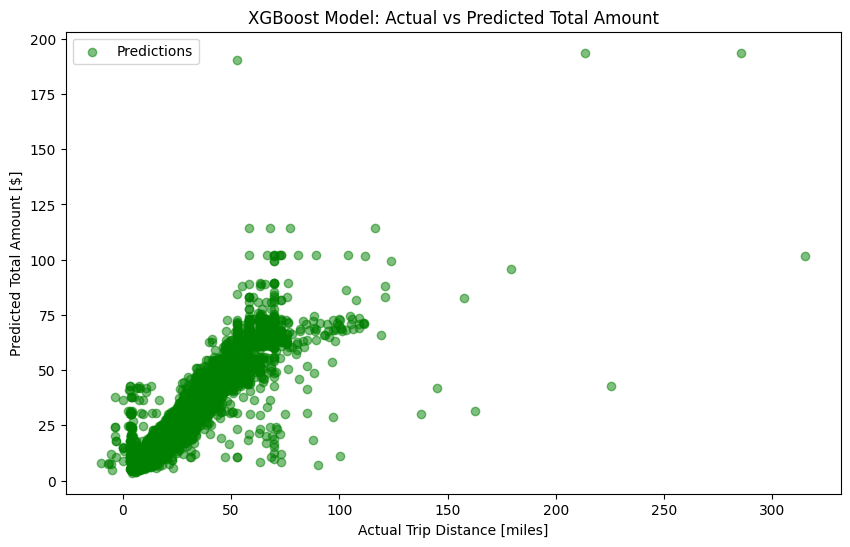

In [97]:
# PLOT MODEL
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb_test, alpha=0.5, color='green', label='Predictions')
plt.xlabel("Actual Trip Distance [miles]")
plt.ylabel("Predicted Total Amount [$]")
plt.title("XGBoost Model: Actual vs Predicted Total Amount")
plt.legend()

In [101]:
# SAVE MODEL
joblib.dump(xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']

In [104]:

# GENERATE MODEL DOCUMENTATION
model_documentation = {
    "model_type": "XGBoost Regressor",
    "features": list(X_train.columns),  # assuming pandas DataFrame
    "feature_importances": {
        feature: float(importance) 
        for feature, importance in zip(X_train.columns, importances)
    },
    "evaluation_metrics": {
        "train": {
            "MAE": mean_absolute_error(y_train, y_pred_xgb),
            "RMSE": rmse,
            "R2": r2_score(y_train, y_pred_xgb)
        },
        "test": {
            "MAE": mean_absolute_error(y_test, y_pred_xgb_test),
            "RMSE": rmse_test,
            "R2": r2_score(y_test, y_pred_xgb_test)
        }
    }
}

# SAVE TO JSON
with open('xgb_model_documentation.json', 'w') as f:
    json.dump(model_documentation, f, indent=4)
